# Perfect-model predictability Module Demo

Aaron Spring and Riley Brady

---

This demo demonstrates the capabilities of the prediction module for a perfect-model framework ensemble simulation.

Input:
- 1-dimensional xr.Dataset timeseries output
- 3-dimensional xr.DataArray maps output

Shows:
- skill score
- predictability horizon
- slow components of internal variability indicating potential predictability
---

In [1]:
import xarray as xr
import numpy as np
import climpred as cp
import matplotlib.pyplot as plt
from climpred.prediction import (compute_perfect_model, PM_sig, 
                                 xr_predictability_horizon, DPP, 
                                 generate_damped_persistence_forecast, 
                                 PM_compute_damped_persistence)
from climpred.stats import (xr_decorrelation_time, xr_varweighted_mean_period, 
                           xr_autocorr)
%matplotlib inline

In [2]:
print(cp.prediction.__doc__)


Objects dealing with decadal prediction metrics.

Concept of calculating predictability skill
-------------------------------------------
- metric: how is skill calculated, e.g. pearson_r, rmse
- comparison: how forecasts and observation/truth are compared, e.g., m2m, e2r

High-level functions
-------------------
- compute_perfect_model: computes the perfect-model predictability skill
according to metric and comparison
- compute_reference: computes predictability/skill relative to some reference
- compute_persistence: computes a persistence forecast from some simulation
- bootstrap from uninitialized ensemble:
    - PM_sig(ds, control, metric=rmse, comparison=_m2m, bootstrap=500, sig=99)
    - threshold to determine predictability horizon

Metrics (submit to functions as strings)
-------
- mse: Mean Square Error
- nev: Normalized Ensemble Variance
- msss: Mean Square Skill Score = ppp: Prognostic Potential Predictability
- rmse and rmse_v: Root-Mean Square Error
- nrmse: Normalized Ro

# Load sample data
Subset of ensembles and members from MPI-ESM-LR (CMIP6 version) esmControl simulation of an early state. vga0214 from year 3000 to 3300.

## 1-dimensional output

1-d output contains datasets of timeseries of a certain averaging **area**s ('global, North_Atlantic') and averaging time **period** (ym, DJF, ...) for some lead **year**s (1..20).
- ds: the ensemble dataset of all **member**s (1..10), **ensemble**s (initialization years: here 3014, 3023, ...), areas, periods and years
- control: the control dataset of all areas, periods and years

In [3]:
ds = xr.open_dataset('../sample_data/prediction/PM_MPI-ESM-LR_ds.nc')
control = xr.open_dataset('../sample_data/prediction/PM_MPI-ESM-LR_control.nc')

In [4]:
ds

<xarray.Dataset>
Dimensions:   (area: 3, ensemble: 12, member: 10, period: 5, time: 20)
Coordinates:
  * time      (time) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
  * period    (period) object 'DJF' 'JJA' 'MAM' 'SON' 'ym'
  * area      (area) object 'global' 'North_Atlantic' 'North_Atlantic_SPG'
  * ensemble  (ensemble) int64 3014 3023 3045 3061 3124 ... 3178 3228 3237 3257
  * member    (member) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    tos       (period, time, area, ensemble, member) float32 ...
    sos       (period, time, area, ensemble, member) float32 ...
    AMO       (period, time, area, ensemble, member) float32 ...

In [5]:
control

<xarray.Dataset>
Dimensions:  (area: 3, period: 5, time: 300)
Coordinates:
  * time     (time) int64 3000 3001 3002 3003 3004 ... 3295 3296 3297 3298 3299
  * period   (period) object 'DJF' 'JJA' 'MAM' 'SON' 'ym'
  * area     (area) object 'global' 'North_Atlantic' 'North_Atlantic_SPG'
Data variables:
    tos      (period, time, area) float32 ...
    sos      (period, time, area) float32 ...
    AMO      (period, time, area) float32 ...

## 3-dimensional output
Data is stored on curvilinear grid: lon(y, x), lat(y, x)

In [6]:
ds3d = xr.open_dataset('../sample_data/prediction/PM_MPI-ESM-LR_ds3d.nc')
control3d = xr.open_dataset('../sample_data/prediction/PM_MPI-ESM-LR_control3d.nc')

In [7]:
ds3d

<xarray.Dataset>
Dimensions:   (ensemble: 4, member: 4, time: 5, x: 256, y: 220)
Coordinates:
    lon       (y, x) float64 ...
    lat       (y, x) float64 ...
  * time      (time) int64 1 2 3 4 5
  * ensemble  (ensemble) int64 3014 3061 3175 3237
Dimensions without coordinates: member, x, y
Data variables:
    tos       (time, ensemble, member, y, x) float32 ...
    sos       (time, ensemble, member, y, x) float32 ...

In [8]:
control3d

<xarray.Dataset>
Dimensions:  (time: 50, x: 256, y: 220)
Coordinates:
    lon      (y, x) float64 ...
    lat      (y, x) float64 ...
  * time     (time) int64 3000 3001 3002 3003 3004 ... 3045 3046 3047 3048 3049
Dimensions without coordinates: x, y
Data variables:
    tos      (time, y, x) float32 ...
    sos      (time, y, x) float32 ...

# Predictability metrics

- available metrics: _rmse, _pearson$_$r, _mse, _PPP, _uACC, _MSSS, _nev

- available comparisons: _m2m, _m2e, _m2c, _e2c

In [9]:
from climpred.prediction import _rmse, _m2e

In [10]:
help(_rmse)

Help on function _rmse in module climpred.prediction:

_rmse(a, b, dim)
    Compute root-mean-square-error (RMSE) of two xr objects.
    See xskillscore.rmse.



In [11]:
help(_m2e)

Help on function _m2e in module climpred.prediction:

_m2e(ds, supervector_dim)
    Create two supervectors to compare all members to ensemble mean.



# 1-dimensional

### Choose predictability metric and comparison

In [12]:
metric='pearson_r'
comparison='m2e'
sig=99
bootstrap=100

In [13]:
def get_limit_sig(metric='pearson_r',sig=sig):
    if metric in ['pearson_r', 'PPP', 'PM_MSSS']:
        limit = 'upper'
        sigl = sig
    else:
        limit = 'lower'
        sigl = 100 - sig
    return limit, sigl

limit, sigl = get_limit_sig(metric=metric, sig=sig)

### Choose varname, area, period

In [14]:
varname='tos'
area='North_Atlantic'
period='ym'

In [15]:
ds_ = ds.sel(area=area,period=period)[varname]
control_ = control.sel(area=area,period=period)[varname]

## Damped persistence forecast
Show damped persistence forecast for one starting year

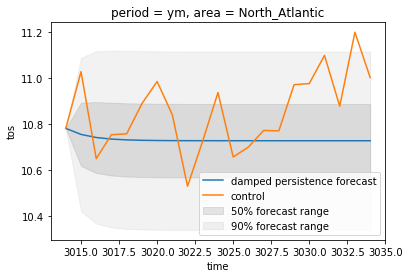

In [16]:
ar1, ar50, ar90 = generate_damped_persistence_forecast(control_,3014)

ar1.plot(label='damped persistence forecast')
plt.fill_between(ar1.index,ar1-ar50,ar1+ar50,alpha=.2,
                 color='gray',label='50% forecast range')
plt.fill_between(ar1.index,ar1-ar90,ar1+ar90,alpha=.1,
                 color='gray',label='90% forecast range')
control_.sel(time=slice(3014,3034)).plot(label='control')
plt.legend()

In [17]:
persistence_skill = PM_compute_damped_persistence(ds_, control_, metric=metric, comparison=comparison)

## skill score against damped persistence

In [18]:
skill = compute_perfect_model(ds_, control_, metric=metric, comparison=comparison)
threshold =  PM_sig(ds_, control_, metric=metric, comparison=comparison, sig=sigl, bootstrap=bootstrap)

In [19]:
ph = xr_predictability_horizon(skill, threshold, limit=limit).values

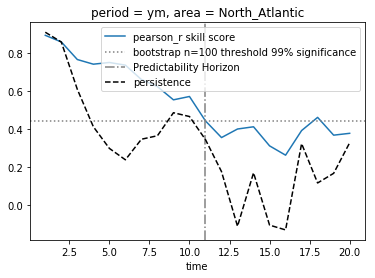

In [20]:
skill.plot(label=metric+' skill score')
plt.axhline(y=threshold, ls=':',c='gray',label='bootstrap n='+str(bootstrap)+' threshold '+str(sig)+'% significance')
plt.axvline(x=ph,ls='-.',c='gray',label='Predictability Horizon')
persistence_skill.plot(ls='--',c='k',label='persistence')
plt.legend()

## skill score of many variables at once

### prediction skill varies with season

In [21]:
skill_many = compute_perfect_model(ds, control, metric=metric, comparison=comparison)

Text(0.5, 1.0, 'tos North_Atlantic Prediction skill varies for different seasons')

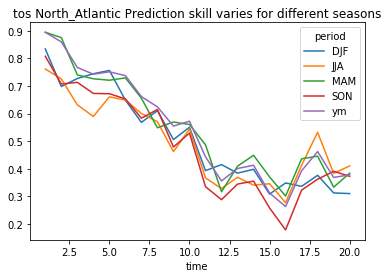

In [22]:
skill_many.sel(area=area).to_dataframe()[varname].unstack().T.plot()
plt.title((' ').join((varname,area,'Prediction skill varies for different seasons')))

### Predictability Horizon

In [23]:
threshold_many = PM_sig(ds, control, metric=metric, comparison=comparison, sig=sigl, bootstrap=bootstrap)

In [24]:
ph_many = xr_predictability_horizon(skill_many, threshold_many, limit=limit)

In [25]:
ph_many.to_dataframe().drop(['quantile'],axis=1).T.astype(int)

area   global                 North_Atlantic                  \
period    DJF JJA MAM SON  ym            DJF JJA MAM SON  ym   
tos         4   4   5   4   5             10  10  11  10  11   
sos        16  16  16  19  18              8  10   5   5   9   
AMO         2   2   3   2   2              2   2   3   2   2   

area   North_Atlantic_SPG                  
period                DJF JJA MAM SON  ym  
tos                    10   9  10   9  10  
sos                     9  10  10  10  10  
AMO                     2   2   3   2   2

## Comparison of comparisons
Skill score results depend on the comparison choosen.

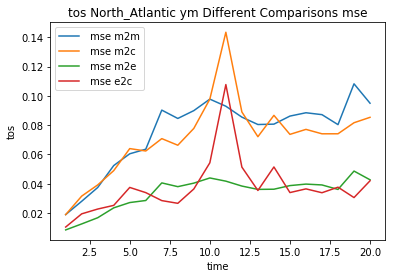

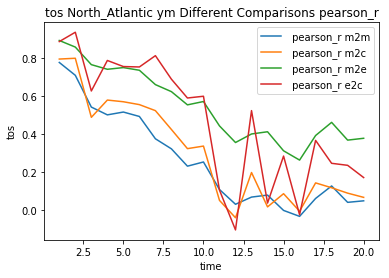

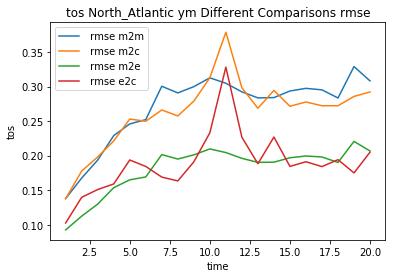

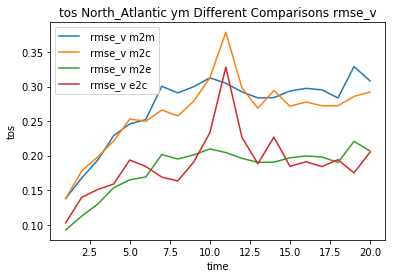

In [26]:
for metric in ['mse', 'pearson_r', 'rmse', 'rmse_v']:
    for c in ['m2m', 'm2c', 'm2e', 'e2c']:
        compute_perfect_model(ds_,control_,metric=metric,comparison=c) \
                         .plot(label=' '+metric+' '+c)
        plt.legend()
        plt.title( ' '.join((varname,area,period,'Different Comparisons',metric)))
    plt.show()

#### proof that two approaches yield equal results
- **$_$rmse** is based on xskillscore and _x2y comparison function
- **$_$rmse$_$v** is based on _ens_var_against_x function
See doc strings for further details.

In [27]:
for c in ['m2m', 'm2e', 'm2c', 'e2c']:
    print((compute_perfect_model(ds_,control_,metric='rmse',comparison=c) / \
           compute_perfect_model(ds_,control_,metric='rmse_v',comparison=c)).mean('time').values)

1.0
1.0
1.0
1.0


## Comparison of metrics

Text(0.5, 1.0, 'tos North_Atlantic ym Different Metrics m2e')

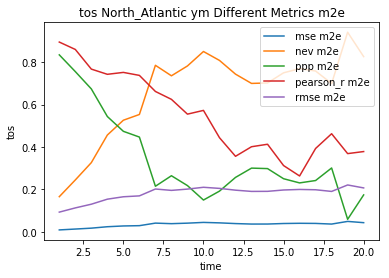

In [28]:
c = 'm2e'
for metric in ['mse', 'nev', 'ppp', 'pearson_r', 'rmse']:
    compute_perfect_model(ds_,control_,metric=metric,comparison=c).plot(label=' '+metric+' '+c)
plt.legend()
plt.title(' '.join((varname,area,period,'Different Metrics',c)))

In [29]:
control_.var('time').values

array(0.05172808)

In [30]:
control_.std('time').values

array(0.22743809)

# 3-dimensional

### Choose predictability metric and comparison

In [31]:
metric='pearson_r'
comparison='m2e'
sig=99
bootstrap=100
limit, sigl = get_limit_sig(metric=metric, sig=sig)

### Skill for Lead Year

better take just xr.DataArray

In [32]:
skill3d = compute_perfect_model(ds3d[varname], control3d[varname], metric=metric, comparison=comparison)

/Users/ribr5703/anaconda/envs/py37/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


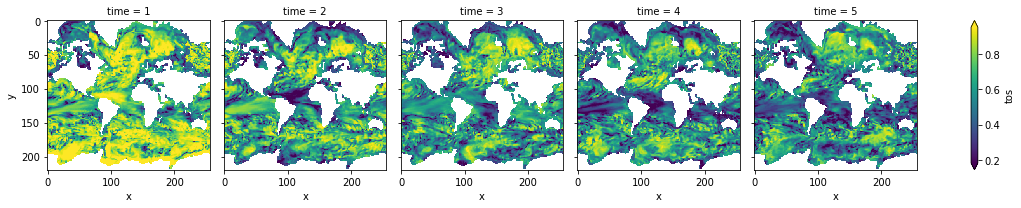

In [33]:
skill3d.plot(robust=True,yincrease=False, col='time')

### Bootstrapped threshold

In [34]:
threshold3d = PM_sig(ds[varname], control3d[varname], metric=metric, comparison=comparison, 
                     sig=sigl, bootstrap=bootstrap)

/Users/ribr5703/anaconda/envs/py37/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/ribr5703/anaconda/envs/py37/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/ribr5703/anaconda/envs/py37/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/ribr5703/anaconda/envs/py37/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/ribr5703/anaconda/envs/py37/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/ribr5703/anaconda/envs/py37/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return 

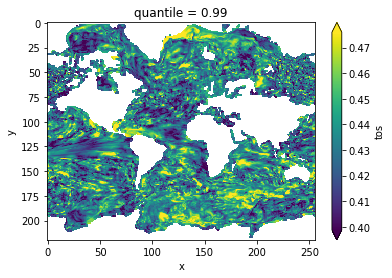

In [35]:
threshold3d.plot(robust=True,yincrease=False)

### Predictability Horizon map

In [36]:
if limit == 'upper':
    masked3d = skill3d.where(skill3d > threshold3d)
elif limit == 'lower':
    masked3d = skill3d.where(skill3d < threshold3d)

Text(0.5, 0.98, 'Skill score if above threshold')

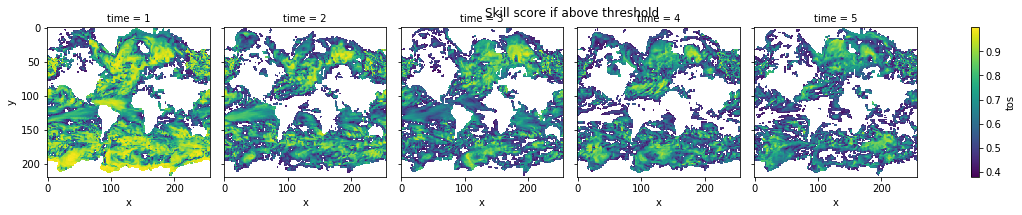

In [37]:
masked3d.plot(yincrease=False, col='time')
plt.suptitle('Skill score if above threshold')

In [38]:
ph3d = xr_predictability_horizon(masked3d, threshold3d, limit=limit)
ph3d.name = 'Lead Years'

Text(0.5, 1.0, 'Predictability Horizon tos')

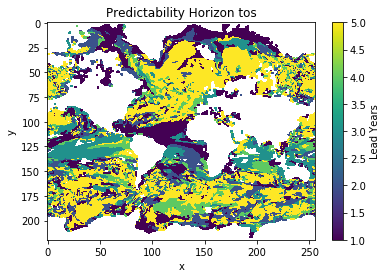

In [39]:
ph3d.where(ph3d>0).plot(robust=False,yincrease=False)
plt.title('Predictability Horizon '+varname)

# Slow components of internal variability indicating potential predictability

Set of methods to show regions indicating chances of predictability:
- Decadal Potential Predictability
- Variance-weighted mean period
- Lag1 autocorrelation
- Decorrelation time

## DPP

In [40]:
help(DPP)

Help on function DPP in module climpred.prediction:

DPP(ds, m=10, chunk=True, var_all_e=False)
    Calculate Diagnostic Potential Predictability (DPP) as potentially
    predictable variance fraction (ppvf) in Boer 2004.
    
    Note: Different way of calculating it than in Seferian 2018 or
    Resplandy 2015, but quite similar results.
    
    References
    ----------
    - Boer, G. J. “Long Time-Scale Potential Predictability in an Ensemble of
        Coupled Climate Models.” Climate Dynamics 23, no. 1 (August 1, 2004):
        29–44. https://doi.org/10/csjjbh.
    - Resplandy, L., R. Séférian, and L. Bopp. “Natural Variability of CO2 and
        O2 Fluxes: What Can We Learn from Centuries-Long Climate Models
        Simulations?” Journal of Geophysical Research: Oceans 120, no. 1
        (January 2015): 384–404. https://doi.org/10/f63c3h.
    - Séférian, Roland, Sarah Berthet, and Matthieu Chevallier. “Assessing the
        Decadal Predictability of Land and Ocean Carbon Uptake.

### Resplandy 2015, Seferian 2018 method

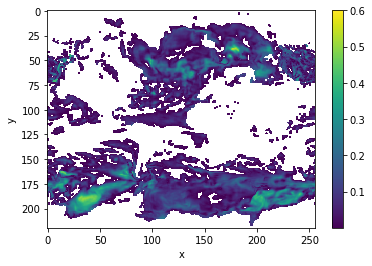

In [41]:
DPP10 = DPP(control3d[varname], m=10, chunk=False)
DPP10.where(DPP10>0).plot(yincrease=False,vmax=.6)

### Original Boer 2004 implementation

/Users/ribr5703/anaconda/envs/py37/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/ribr5703/anaconda/envs/py37/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


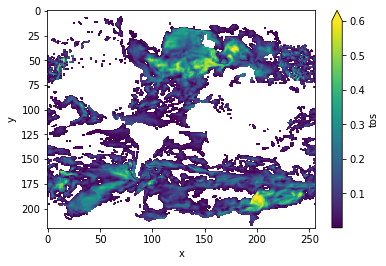

In [42]:
DPP10 = DPP(control3d[varname], m=10, chunk=True)
DPP10.where(DPP10>0).plot(yincrease=False,vmax=.6)

yields similar results

## varweigthed mean period

In [43]:
help(xr_varweighted_mean_period)

Help on function xr_varweighted_mean_period in module climpred.stats:

xr_varweighted_mean_period(ds, time_dim='time')
    Calculate the variance weighted mean period of an xr.DataArray.
    
    Reference
    ---------
    - Branstator, Grant, and Haiyan Teng. “Two Limits of Initial-Value Decadal
      Predictability in a CGCM.” Journal of Climate 23, no. 23 (August 27,
      2010): 6292-6311. https://doi.org/10/bwq92h.



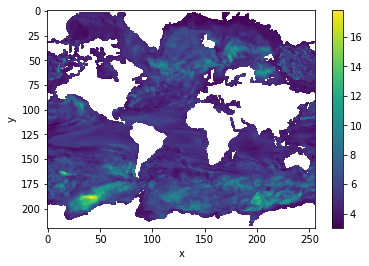

In [47]:
from climpred.stats import xr_varweighted_mean_period as xvmp
varweighted_mean_period = xvmp(control3d[varname],time_dim='time')
varweighted_mean_period.plot(yincrease=False)

## Lag1 autocorrelation

In [48]:
help(xr_autocorr)

Help on function xr_autocorr in module climpred.stats:

xr_autocorr(ds, lag=1, dim='time', return_p=False)
    Calculated lagged correlation of a xr.Dataset.
    
    Parameters
    ----------
    ds : xarray dataset/dataarray
    lag : int (default 1)
        number of time steps to lag correlate.
    dim : str (default 'time')
        name of time dimension/dimension to autocorrelate over
    return_p : boolean (default False)
        if false, return just the correlation coefficient.
        if true, return both the correlation coefficient and p-value.
    
    Returns
    -------
    r : Pearson correlation coefficient
    p : (if return_p True) p-value



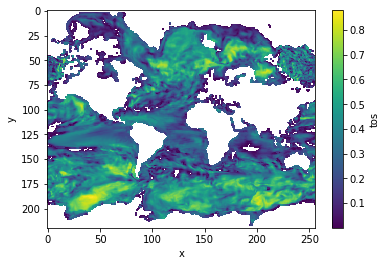

In [49]:
corr_ef = xr_autocorr(control3d[varname],dim='time')
corr_ef.where(corr_ef>0).plot(yincrease=False, robust=False)

## Decorrelation time

In [50]:
help(xr_decorrelation_time)

Help on function xr_decorrelation_time in module climpred.stats:

xr_decorrelation_time(da, r=20, dim='time')
    Calculate decorrelation time of an xr.DataArray.
    
    tau_d = 1 + 2 * sum_{k=1}^(infinity)(alpha_k)**k
    
    Parameters
    ----------
    da : xarray object
    r : int (default 20)
        Number of iterations to run of the above formula
    dim : str (default 'time')
        Time dimension for xarray object
    
    Reference
    ---------
    - Storch, H. v, and Francis W. Zwiers. Statistical Analysis in Climate
    Research. Cambridge ; New York: Cambridge University Press, 1999., p.373



/Users/ribr5703/anaconda/envs/py37/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


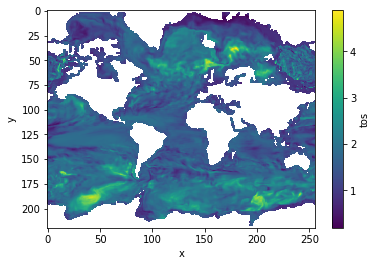

In [51]:
decorr_time = xr_decorrelation_time(control3d[varname])
decorr_time.where(decorr_time>0).plot(yincrease=False, robust=False)